In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [17]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
PALETTE = px.colors.qualitative.Prism

In [18]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_labeled.parquet')

In [19]:
df_hosts_reviews_en = df_hosts_reviews_en.query('sentiment_label_class == 0').reset_index()

In [20]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['stayed', 'three', 'nights', 'couldnt', 'helpful', 'soon', 'got', 'showed', 'us', 'get', 'around', 'visit', 'place', 'conveniently', 'located', 'metro', 'station', 'walking', 'distance', 'market', 'many', 'restaurants', 'clean', 'privacy', 'issue', 'despite', 'guests', 'staying', 'well', 'wifi', 'reliable', 'youre', 'vacation', 'doesnt', 'really', 'matter']


In [21]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words(data_words)

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=5,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.020*"host" + 0.016*"room" + 0.016*"stay" + 0.015*"apartment" + 0.013*"bed" + 0.013*"place" + 0.012*"leave" + 0.012*"clean" + 0.010*"dirty" + 0.010*"get"'),
 (1,
  '0.038*"location" + 0.030*"apartment" + 0.022*"host" + 0.018*"need" + 0.015*"stay" + 0.015*"place" + 0.014*"close" + 0.011*"great" + 0.009*"cleanliness" + 0.009*"right"')]

In [23]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # create a dataframe
    sent_topics_df = pd.DataFrame(columns=['dominant_topic', 'percent_contribution', 'topic_keywords'])

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,3), topic_keywords]
            else:
                break


    # merge the original dataframe to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.sample(3)

,level_0,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,...,review_scores_location,review_scores_value,comments_language,description_language,sentiment_label,sentiment_label_class,dominant_topic,percent_contribution,topic_keywords,text
490,35795,2019-10-25,861.0,2.405385e+07,13516786.0,Stu,second stay,167667174.0,Emi,enkelt boende bright clean simple accommodatio...,...,4.68,4.83,en,en,0.0,0,0,0.801,"host, room, stay, apartment, bed, place, leave...","[second, stay]"
572,40475,2022-05-31,1038.0,2.945529e+07,139552837.0,Karlo,hospitable host,1293314.0,Tommy,fluffy doglux apt centralroom one many 5star r...,...,4.95,4.82,en,en,0.0,0,1,0.799,"location, apartment, host, need, stay, place, ...","[hospitable, host]"
1152,65736,2022-03-12,2068.0,5.670530e+17,35702592.0,Bernhard,clean rooms stink,445786422.0,Acco,acco private single room stockholm södermalm p...,...,4.36,3.86,en,en,0.0,0,0,0.872,"host, room, stay, apartment, bed, place, leave...","[clean, room, stink]"


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.153722  0.0       1        1  69.504701
1     -0.153722  0.0       2        1  30.495299, topic_info=          Term        Freq       Total Category  logprob  loglift
33    location  232.000000  232.000000  Default  30.0000  30.0000
138       need  117.000000  117.000000  Default  29.0000  29.0000
22   apartment  395.000000  395.000000  Default  28.0000  28.0000
154      close   90.000000   90.000000  Default  27.0000  27.0000
168      great   70.000000   70.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
27        host  135.312226  414.232748   Topic2  -3.8199   0.0688
10       place   89.556649  265.530070   Topic2  -4.2327   0.1007
17        stay   91.720901  311.091897   Topic2  -4.2088  -0.0337
533       poor   31.308702   45.396015   Topic2  -5.2836   0.8161
176      space   32.156870   48.859902   Topic2  -5.2569   0.7693

[121 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
127       1  0.111411  advertise
127       2  0.891291  advertise
261       1  0.992813     airbnb
261       2  0.007579     airbnb
22        1  0.531150  apartment
...     ...       ...        ...
148       2  0.011235       want
338       1  0.995798     window
338       2  0.014644     window
515       1  0.996185       work
515       2  0.011859       work

[153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [25]:
topics = lda_model.show_topics(formatted=False)

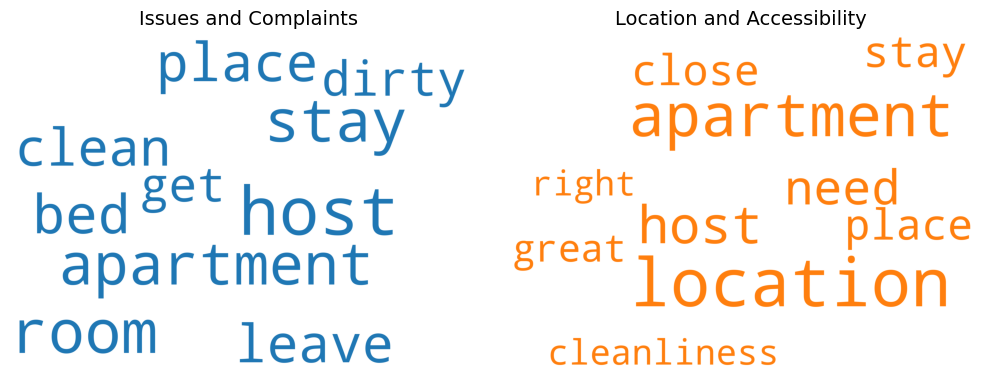

In [26]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

groups = {0: 'Issues and Complaints',
          1: 'Location and Accessibility',
          2: 'Host and Service Experience'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=10)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [27]:
numnber_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood', 'dominant_topic'])
        .agg(number_of_reviews=('number_of_reviews', 'count'))
        .sort_values('number_of_reviews', ascending=False)
        .reset_index())
numnber_topic_by_neighbourhood 

,neighbourhood,dominant_topic,number_of_reviews
0,Södermalm,0,321
1,Södermalm,1,276
2,Kungsholmen,0,86
3,Norrmalm,0,81
4,Kungsholmen,1,80
5,Norrmalm,1,67
6,Enskede-Årsta-Vantör,1,38
7,Enskede-Årsta-Vantör,0,30
8,Hägersten-Liljeholmen,0,23
9,Östermalm,0,20


In [28]:
# Define a custom color mapping function
def get_tile_color(tile_path):
    # Get the name of the neighbourhood and the dominant topic from the tile path
    neighbourhood, dominant_topic = tile_path[-2:]

    # Assign a specific color to each combination of neighbourhood and dominant topic
    if dominant_topic == 'topic 0' and neighbourhood == 'Neighbourhood 1':
        return 'red'
    elif dominant_topic == 'topic 1' and neighbourhood == 'Neighbourhood 2':
        return 'green'
    else:
        # Use the default color scale for all other tiles
        return None

# Create the treemap with the custom color mapping function
fig = px.treemap(
    numnber_topic_by_neighbourhood,
    path=['neighbourhood', 'dominant_topic'],
    values='number_of_reviews',
    color_discrete_sequence=PALETTE,
    color_continuous_midpoint=np.average(numnber_topic_by_neighbourhood['number_of_reviews']),
)

# Apply the custom color mapping function to each tile
fig.data[0].marker.colors = [get_tile_color(tile_path) for tile_path in fig.data[0].ids]

# Show the figure
fig.show()